# Can we predict disasters from tweets using NLP?
This is a Kaggle's "Getting Started" competition. I used [Natural Language Toolkit (nltk)](https://www.nltk.org/), feature extraction, gradient descent and logistic regression to solve this problem.

## Section 1: Setup

In [1]:
# packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

# include keywords and locations?
include_all = False

# balance the number of disaster and non-disaster tweets
balance = True

In [2]:
# functions
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)
    return tweets_clean

def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()
    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    '''
    return 1/(1+np.exp(-z))

def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))     
    #bias term is set to 1
    x[0,0] = 1    
    # loop through each word in the list of words
    for word in word_l:        
        for key, value in freqs.items():
            if word==key[0] and key[1]==1:
                # increment the word count for the positive label 1
                x[0,1] += freqs[(word,1)]
            if word==key[0] and key[1]==0:
                # increment the word count for the negative label 0
                x[0,2] += freqs[(word,0)]
    return x

def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # get 'm', the number of rows in matrix x
    m = x.shape[0]
    y = y.reshape((m,1))
    J = np.zeros(num_iters)
    acc = np.zeros(num_iters)
    thetaarr = np.zeros((num_iters+1,3))
    thetaarr[0,:] = theta[:,0]*0
    for i in range(num_iters):        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)        
        # get the sigmoid of z
        h = sigmoid(z)
        # calculate the cost function
        J[i] = -(np.sum(y*np.log(h))+np.sum((1-y)*np.log(1-h)))/float(m)
        acc[i] = np.sum((h>=0.5)*1 == y)/float(m)
        # update the weights theta
        theta = theta - alpha*(np.dot(x.T,h-y))/float(m)
        thetaarr[i+1,:] = theta[:,0]
    plt.figure(figsize=[12,5])
    plt.subplot(121)
    plt.plot(thetaarr[:,0],label='bias')
    plt.plot(thetaarr[:,1],label='w1')
    plt.plot(thetaarr[:,2],label='w2')
    plt.xlabel('number of iterations')
    plt.subplot(122)
    plt.plot(acc)
    plt.ylabel('accuracy')
    plt.xlabel('number of iterations')
    return J, theta, acc

def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))    
    return y_pred

def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """ 
    # the list for storing predictions
    y_hat = []
    test_y = np.array(test_y)
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)        
        if y_pred >= 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)
    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = np.sum(np.array(y_hat)==np.squeeze(test_y))/len(y_hat)    
    return accuracy

In [3]:
# extract the data
train = pd.read_csv('train.csv')
npos = np.sum(train["target"]==1)
nneg = np.sum(train["target"]==0)
print('number of tweets: ',train.shape[0])
print('number of disasters: ',npos)
print('number of non-disasters: ',nneg)
train.head()

number of tweets:  7613
number of disasters:  3271
number of non-disasters:  4342


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test = pd.read_csv('test.csv')
print('number of tweets in test data: ',test.shape[0])
# test.head()

number of tweets in test data:  3263


In [5]:
# split the data into training and validation sets
if include_all:
    train_text = train['text'].tolist()
    train_key = train['keyword'].tolist()
    train_loc = train['location'].tolist()
    train_data = []
    for j in range(train.shape[0]):
        train_data.append(train_text[j]+' '+str(train_key[j])+' '+str(train_loc[j]))
else:
    train_data = train['text'].tolist()

train_label = train['target'].tolist()
val_data = train_data[7513:]
val_label = train_label[7513:]
train_data = train_data[1:7513]
train_label = train_label[1:7513]
test_data = test['text']
test_id = test['id']

In [6]:
# format the data
# train data and labels
freqs = build_freqs(train_data,train_label) # used for all subsequent feature extractions
scores = freqs.copy()
cutoff_factor = 1./3
for pair in scores:
    if balance:
        if pair[1] == 1: # disaster
            scores[pair] = np.tanh(freqs[pair]*(npos+nneg)/npos*cutoff_factor)
        else:
            scores[pair] = np.tanh(freqs[pair]*(npos+nneg)/nneg*cutoff_factor)
    else:
        scores[pair] = np.tanh(freqs[pair]*cutoff_factor)
        
X = np.zeros((len(train_data), 3))
for i in range(len(train_data)):
    X[i, :]= extract_features(train_data[i], scores)
Y = np.array(train_label)

## Section 2: Model

The resulting vector of weights is [[-0.25510669]
 [ 1.33586666]
 [-1.34368762]]
The accuracy is 0.9187965921192758


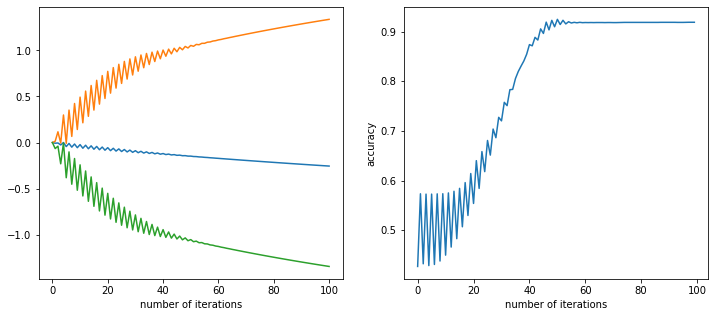

In [7]:
# # apply gradient descent & evaluate the model with test data
J, theta, acc = gradientDescent(X, Y, np.zeros((3, 1)), 1e-1, 100)
print(f"The resulting vector of weights is {theta}")
print(f"The accuracy is {acc[-1]}")

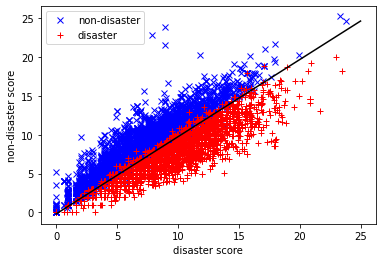

In [8]:
# Check
plt.figure()
plt.plot(X[Y==0,1],X[Y==0,2],'bx',label='non-disaster')
plt.plot(X[Y==1,1],X[Y==1,2],'r+',label='disaster')
plt.legend()
plt.xlabel('disaster score')
plt.ylabel('non-disaster score')
x = np.arange(0,26,5)
plt.plot(x,-(theta[0]+theta[1]*x)/theta[2],'k')

model's accuracy for validation set = 0.8800


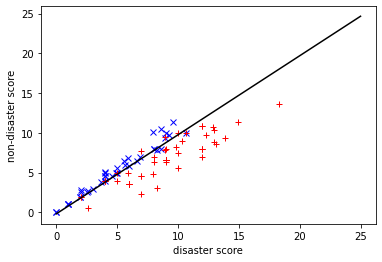

In [9]:
# validation data and labels
X_val = np.zeros((len(val_data), 3))
for i in range(len(val_data)):
    X_val[i, :]= extract_features(val_data[i], scores)
Y_val = np.array(val_label)
plt.figure()
plt.plot(X_val[Y_val==0,1],X_val[Y_val==0,2],'bx',label='non-disaster')
plt.plot(X_val[Y_val==1,1],X_val[Y_val==1,2],'r+',label='disaster')
plt.plot(x,-(theta[0]+theta[1]*x)/theta[2],'k')
plt.xlabel('disaster score')
plt.ylabel('non-disaster score')

accuracy = test_logistic_regression(val_data, val_label, scores, theta)
print(f"model's accuracy for validation set = {accuracy:.4f}")

The model is simple with very few parameters to fit. As expected, the accuracy of 0.88 is not very high.

In [10]:
pred = []
for tweet in test_data:
    pred.append(predict_tweet(tweet, scores, theta)[0,0])
predictions = np.multiply(np.array(pred)>=0.5, 1)
df = pd.DataFrame(data={'id':test_id,'target': np.transpose(predictions).tolist()[0]})
df.head()
df.to_csv('submission_nltk_logistic.csv',index=False)